[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# GPT-4o Research Agent in LangGraph

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing. Most research agents are packed up into their own frameworks, like BlockAGI and others.

In this example, we want to demonstrate how we can build our own AI research agent using `gpt-4o`, Pinecone, LangGraph, arXiv, and Google via the SerpAPI.

In [ ]:
# pip install cohere==5.9.0 # to resolve error with 5.13.12

## Research Agent Overview

Our research agent will consist of a function calling AI agent that has access to several tools that it can use to find information on a particular topic. It will be able to use several tools over multiple steps, meaning it can find information on one topic, broaden the scope of knowledge on this topic and _even_ investigate parallel topics where relevant.

The tools we will be using are:

* **ArXiv paper fetch**: Given an arXiv paper ID, this tool provides our agent with the abstract of the paper.
* **Web search**: This tool provides our agent with access to Google search for more generalized queries.
* **RAG search**: We will create a knowledge base containing AI arXiv papers. This tool provides our agent with access to this knowledge.
* **RAG search with filter**: Sometimes our agent may need more information from a specific paper, this tool allows our agent to do just that.
* **Final answer**: We create a custom final answer tool that forces our agent to output information in a specific format like:

```
INTRODUCTION
------------
<some intro to our report>

RESEARCH STEPS
--------------
<the steps the agent took during research>

REPORT
------
<the report main body>

CONCLUSION
----------
<the report conclusion>

SOURCES
-------
<any sources the agent used>
```

## Setup Knowledge Base

We'll be running our agent against a knowledge base — which requires a Pinecone index to be built.

You can, if needed, skip this step and replace the `search` tool with a placeholder value if wanting to quickly test the structure of a RAG agent _without_ the RAG.

If you want full functionality here, you do need to run this section — but we'll make it quick.

### Download a Dataset

The first thing we need for an agent using RAG is somewhere we want to pull knowledge from. We will use v2 of the AI ArXiv dataset, available on Hugging Face Datasets at [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks).

Note: we're using the prechunked dataset. For the raw version see [`jamescalam/ai-arxiv2`](https://huggingface.co/datasets/jamescalam/ai-arxiv2).

In [2]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

c:\Users\sande\miniconda3\envs\LangGraph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [3]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

In [4]:
dataset[1]

{'id': '2401.04088#1',
 'title': 'Mixtral of Experts',
 'content': 'Code: https://github.com/mistralai/mistral-src Webpage: https://mistral.ai/news/mixtral-of-experts/ # Introduction In this paper, we present Mixtral 8x7B, a sparse mixture of experts model (SMoE) with open weights, licensed under Apache 2.0. Mixtral outperforms Llama 2 70B and GPT-3.5 on most benchmarks. As it only uses a subset of its parameters for every token, Mixtral allows faster inference speed at low batch-sizes, and higher throughput at large batch-sizes. Mixtral is a sparse mixture-of-experts network. It is a decoder-only model where the feedforward block picks from a set of 8 distinct groups of parameters. At every layer, for every token, a router network chooses two of these groups (the â',
 'prechunk_id': '2401.04088#0',
 'postchunk_id': '2401.04088#2',
 'arxiv_id': '2401.04088',
 'references': ['1905.07830']}

Building a knowledge base:

In [6]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder
from load_dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

In [7]:
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# configure client
pc = Pinecone(api_key=api_key)

In [16]:
from pinecone import ServerlessSpec

spec = ServerlessSpec(
    cloud="aws", region="us-east-1"  # us-east-1
)

In [17]:
dims = len(encoder(["some random text"])[0])
dims

1536

In [18]:
import time

index_name = "gpt-4o-mini-research-agent"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=dims,  # dimensionality of embed 3
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [19]:
pc.list_indexes().names()

['gpt-4o-mini-research-agent']

Populate our knowledge base:

In [20]:
from tqdm.auto import tqdm

# easier to work with dataset as pandas dataframe
data = dataset.to_pandas().iloc[:10000]

batch_size = 128

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end].to_dict(orient="records")
    # get batch of data
    metadata = [{
        "title": r["title"],
        "content": r["content"],
        "arxiv_id": r["arxiv_id"],
        "references": r["references"].tolist()
    } for r in batch]
    # generate unique ids for each chunk
    ids = [r["id"] for r in batch]
    # get text content to embed
    content = [r["content"] for r in batch]
    # embed text
    embeds = encoder(content)
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

100%|██████████| 79/79 [03:08<00:00,  2.39s/it]


## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [21]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. This can include things like "search arxiv", "perform general purpose web search", etc. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### ArXiv Paper Fetch

The `fetch_arxiv` tool will allow our agent to get the summary of a specific paper given an ArXiv paper ID. To do this, we will simply send a GET request to arXiv and use regex to extract the paper abstract.

In [22]:
import requests

# we will test with the mixtral paper
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

There's a lot going on there. Fortunately, we can use some _relatively_ straightforward regex to find the paper abstract.

In [23]:
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# we search
re_match = abstract_pattern.search(res.text)

# and now let's see what we got
print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


Now we pack all of this logic into a tool for our agent to use.

In [24]:
from langchain_core.tools import tool


@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test the tool.

In [25]:
print(
    fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
)

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [28]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

search = GoogleSearch({
    **serpapi_params,
    "q": "coffee"
})

results = search.get_dict()["organic_results"]

In [29]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [30]:
print(contexts)

Coffee
Coffee is a beverage brewed from roasted, ground coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a stimulating effect on humans, ...
https://en.wikipedia.org/wiki/Coffee
---
Peet's Coffee | The Original Craft Coffee, Est. 1966
Since 1966, Peet's Coffee has sourced and offered superior coffees and teas and adhering to strict high-quality and taste standards. Shop today.
https://www.peets.com/
---
r/Coffee
thread where you can share what you are brewing or ask for bean recommendations. This is a place to share and talk about your favorite coffee roasters or beans.
https://www.reddit.com/r/Coffee/
---
Starbucks Coffee Company
More than just great coffee. Explore the menu, sign up for Starbucks® Rewards, manage your gift card and more.
https://www.starbucks.com/
---
The Coffee Bean & Tea Leaf | CBTL
We're passionate about delivering the best handcrafted products and take pride in the journey from seed to cup.
https://coffeebean.com/
---
Specialty Coffee Lake Ta

We put this process into a tool:

In [31]:
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

### RAG Tools

We provide two RAG-focused tools for our agent. The `rag_search` allows the agent to perform a simple RAG search for some information across _all_ indexed research papers. The `rag_search_filter` also searches, but _within_ a specific paper which is filtered for via the `arxiv_id` parameter.

We also define the `format_rag_contexts` function to handle the transformation of our Pinecone results from a JSON object to a readble plaintext format.

In [32]:
from langchain_core.tools import tool

def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Content: {x['metadata']['content']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
            f"Related Papers: {x['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=2, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [33]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [34]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [36]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

Test the agent quickly to confirm it is functional:

In [40]:
inputs = {
    "input": "tell me something interesting about dogs",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tvWRWhOw53F6VpRzEzw0MViA', 'function': {'arguments': '{"query":"interesting facts about dogs"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 539, 'total_tokens': 557, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-096440bf-a121-4f6b-bf82-ce1728b8c48a-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_tvWRWhOw53F6VpRzEzw0MViA'}], usage_metadata={'input_tokens': 539, 'output_tokens': 18, 'total_tokens': 557})

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [41]:
out.tool_calls[0]["name"]

'web_search'

In [42]:
out.tool_calls[0]["args"]

{'query': 'interesting facts about dogs'}

We can see now that our Oracle decided to use the `web_search` tool with a `query` of `"interesting facts about dogs"` — a good choice.

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [43]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [44]:
tool_str_to_func = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [45]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

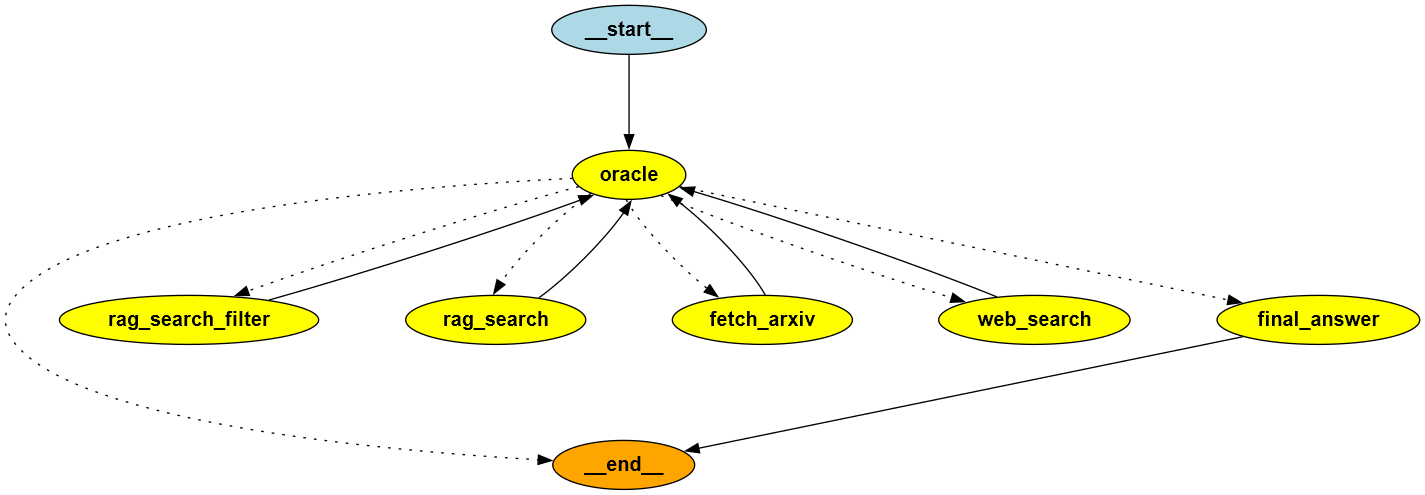

In [46]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [47]:
out = runnable.invoke({
    "input": "tell me something interesting about dogs",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'interesting facts about dogs'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'interesting facts about dogs'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'interesting facts about dogs'}, log="Interesting Facts About Dogs\n– When a puppy is born, he is blind, deaf, and toothless. – All dogs, regardless of breed, are direct descendants of wolves and technically of the same species.\nhttps://www.mspca.org/pet_resources/interesting-facts-about-dogs/\n---\n30 Fun and Fascinating Dog Facts\n6. A dog's sense of smell is legendary, but did you know that their nose has as many as 300 million receptors? In comparison, a human nose has about 5 million.\nhttps://www.akc.org/expert-advice/lifestyle/dog-facts/\n---\nDog facts for kids!\nDog facts! · 1. Dogs are the most popular pet on the planet! · 2. They evolved from a now-extinct species of wolf. · 3. They can learn over

Let's create a function to consume the agent output and format it into our report:

In [48]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [49]:
out["intermediate_steps"][-1].tool_input

{'introduction': 'Dogs are fascinating creatures that have been companions to humans for thousands of years. Their unique characteristics and abilities make them one of the most beloved pets worldwide.',
 'research_steps': "1. Conducted a web search for interesting facts about dogs. 2. Reviewed multiple sources to gather diverse information. 3. Compiled notable facts about dogs' abilities and history.",
 'main_body': 'One of the most remarkable aspects of dogs is their incredible sense of smell. Dogs possess up to 300 million olfactory receptors in their noses, compared to about 5 million in humans. This extraordinary sense allows them to detect scents at incredibly low concentrations, making them invaluable in search and rescue operations, as well as in detecting diseases such as cancer. \n\nAdditionally, dogs are known for their strong bond with humans, which has been cultivated over thousands of years of coevolution. They can read human facial expressions and interpret gestures, sho

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Dogs are fascinating creatures that have been companions to humans for thousands of years. They are known for their loyalty, intelligence, and diverse abilities. Here are some interesting facts about dogs that highlight their unique characteristics and behaviors.

RESEARCH STEPS
--------------
1. Conducted a specialist search on ArXiv for any research papers or articles related to interesting facts about dogs.
2. Performed a web search to gather general knowledge and fun facts about dogs from various reputable sources.

REPORT
------
Dogs were the first animals to be domesticated by humans, with evidence suggesting this occurred over 20,000 years ago. As they evolved from wolves, their physical features such as skulls, teeth, and paws became smaller. Today, there are more than 150 dog breeds, categorized into eight classes: sporting, hound, working, terrier, toy, non-sporting, herding, and miscellaneous.

One of the most remarkable abilities of dogs is their 

Now let's try with an on-topic question on AI.

In [50]:
out = runnable.invoke({
    "input": "tell me about AI",
    "chat_history": []
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'artificial intelligence overview'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'artificial intelligence overview'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'artificial intelligence overview'}, log="What Is Artificial Intelligence (AI)?\nAI is technology that enables computers and machines to simulate human learning, comprehension, problem solving, decision making, creativity and autonomy.\nhttps://www.ibm.com/think/topics/artificial-intelligence\n---\nWhat Is Artificial Intelligence with Examples & Uses\nArtificial intelligence (AI) is the simulation of human intelligence in machines that are programmed to think and act like humans.\nhttps://www.simplilearn.com/tutorials/artificial-intelligence-tutorial/what-is-artificial-intelligence\n---\nOverview of Artificial Intelligence Technology\nThe term artificial intelligence broadly refers to applications of 

In [51]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Artificial Intelligence (AI) is a transformative technology that enables machines to perform tasks that typically require human intelligence. This includes capabilities such as learning, reasoning, problem-solving, and decision-making. AI has become a pivotal part of various industries, influencing how we interact with technology and each other.

RESEARCH STEPS
--------------
1. Conducted a web search to gather a broad overview of AI definitions and applications. 2. Reviewed multiple sources to ensure a comprehensive understanding of AI's capabilities and significance. 3. Compiled the information into a cohesive report.

REPORT
------
AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and act like humans. This technology encompasses a variety of functions, including learning from experience, understanding natural language, recognizing patterns, and making decisions. AI systems can be categor

Let's ask about RAG specifically.

In [52]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'retrieval augmented generation'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log="Title: AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation\nContent: Due to the page limit, details of the evaluation, including case studies in three scenarios are in Appendix D. # A2: Retrieval-Augmented Code Generation and Question Answering Retrieval augmentation has emerged as a practical and effective approach for mitigating the intrinsic limitations of LLMs by incorporating external documents. In this section, we employ AutoGen to build a Retrieval-Augmented Generation (RAG) system (Lewis et al., 2020; Parvez et al., 2021) named Retrieval-augmented Chat. The system consists of two agents: a Retrieval-augmented User Proxy agent and a Retri

In [53]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Retrieval-Augmented Generation (RAG) is an innovative approach in the field of artificial intelligence that enhances the capabilities of large language models (LLMs) by integrating external information sources. This technique aims to improve the accuracy and reliability of generative AI outputs by grounding them in authoritative knowledge bases.

RESEARCH STEPS
--------------
1. Conducted a search for academic papers on retrieval-augmented generation to gather detailed insights.
2. Searched for definitions and applications of RAG in various AI contexts using web resources.
3. Compiled information from both academic and general knowledge sources to provide a comprehensive overview.

REPORT
------
Retrieval-Augmented Generation (RAG) is a framework that combines the strengths of traditional information retrieval systems with generative AI models. By incorporating external documents and knowledge bases, RAG addresses the limitations of LLMs, which may struggle w

---